This notebook aims to predict Sales using XGBoost regressor

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from yellowbrick.regressor import ResidualsPlot
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## Read data from file

In [2]:
data_df = pd.read_csv('train_data_cleaned.csv')
data_df.shape

(2939, 27)

In [3]:
data_df.head(2)

,year_week,recipe_id,recipe_name,product_type,calories,carbs,cooking_time,cuisine,description,difficulty,dish_type,heat_level,fat,is_classic,number_of_ingredients_per_recipe,preferences,carbs_content,dish_types,seasons,protein_types,proteins,course_type,cooking_tip,meta_tags,percentage_of_local_ingredients,protein_cuts,sales
0,201801,14919,Shrimp & Broccoli Stir-Fry,2 person,687.0,99.2,time_level_4,asian,"For this dish, once the ingredients are preppe...",easy,fish,optional_heat,18.6,No,7,shellfish,rice,"fish_and_side,stir_fry",all_seasons,shellfish,29.5,main,NaN,healthy_choice,0.0,NaN,3567
1,201801,14920,Caramelized Cabbage Pasta,2 person,779.0,81.3,time_level_4,new_american,Red lentil penne makes this pasta dish a pleas...,easy,veggie,no_heat,38.5,No,5,no_protein,pasta_incl_gnocchi_spatzle,pasta,all_seasons,no_protein,30.0,main,NaN,quick,0.0,no_cut,2532


## Explore the dataset

Let's have a look at what independent variables we have, and their types

In [4]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2939 entries, 0 to 2938
Data columns (total 27 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   year_week                         2939 non-null   int64  
 1   recipe_id                         2939 non-null   int64  
 2   recipe_name                       2939 non-null   object 
 3   product_type                      2939 non-null   object 
 4   calories                          2933 non-null   float64
 5   carbs                             2892 non-null   float64
 6   cooking_time                      2648 non-null   object 
 7   cuisine                           2106 non-null   object 
 8   description                       2935 non-null   object 
 9   difficulty                        2930 non-null   object 
 10  dish_type                         2521 non-null   object 
 11  heat_level                        2223 non-null   object 
 12  fat   

Here we already see:

- Dataset has 2939 entries

- Sales is the dependent variable

- We have a bunch of continuous independent variables, such as calories, carbs, fat, number_of_ingredients, proteins, or percentage_of_local_ingredients.

- We have a bunch of categorical variables, such as product_type, cooking_time, cuisine, difficulty, dish_type, heat_level, is_classic,  preferences', carbs_content, dish_types, seasons, protein_types, course_type,  meta_tags, or protein_cuts

- There are missing values that may need to be taken care off (depending on the algorithm we use).

- cooking_tip is completely empty, so we can drop it.

### What does each row represent?

Now let's try to find out what each row represents by finding the unique identifier. Looking at the variable names, my guess is, each row is either a recipe, or a recipe at a particular week.   

In [5]:
print('Unique recipe_id') if len (data_df) == len(data_df[['recipe_id']].drop_duplicates()) else print ("Not Unique recipe_id")
print('Unique year_week and recipe_id') if len (data_df) == len(data_df[['year_week', 'recipe_id']].drop_duplicates()) else print ("Not Unique year_week and recipe_id")


Not Unique recipe_id
Unique year_week and recipe_id


It looks like each row is a recipe - year_week combination.

### How many levels do our categorical variables have?

In [6]:
categorical_var = ['product_type', 'cooking_time', 'cuisine', 'difficulty', 'dish_type', 'heat_level', 'is_classic',  'preferences', 'carbs_content', 'dish_types', 'seasons', 'protein_types', 'course_type',  'meta_tags', 'protein_cuts']

for variable in categorical_var:
    print(variable)
    print(data_df[variable].value_counts())
    print('\n')


product_type
2 person    1339
family      1335
z_amazon     216
add_on        49
Name: product_type, dtype: int64


cooking_time
time_level_4    1359
time_level_5    1121
time_level_3     145
time_level_6      19
time_level_7       4
Name: cooking_time, dtype: int64


cuisine
new_american              897
italian                   338
asian                     239
mexican                   128
asian_fusion               91
mediterranean              82
central_south_american     54
indian                     42
european                   36
middle_eastern             30
thai                       30
american                   25
french                     18
british_irish              16
japanese                   14
german                     12
eastern_european            8
vietnamese                  8
north_african               8
greek                       6
fusion                      6
tex_mex                     6
caribbean                   4
chinese                     2
kor

Here we can already see:

- some variables have just one level, therefore they are nor useful and can be droped: difficulty, is_classic, course_type

- Some variables include multiple labels in a single row and need to be treated:

    * preferences, carbs_content, dish_types, seasons, protein_types, meta_tags 

### How do continuous variables look like? Do we have outliers?

There are several things we can do to detect outliers.

- Visually, we can just plot the data with a boxplot (which uses IQR scores)

- We can calculate the Z-scores, and see is there are data points too far from the mean (for instance, with a higher z-score than 3, that is, 3 standard deviations from the mean).


For this exercise we will just plot boxplots

In [7]:
data_df.describe()

,year_week,recipe_id,calories,carbs,fat,number_of_ingredients_per_recipe,proteins,cooking_tip,percentage_of_local_ingredients,sales
count,2939.000000,2939.000000,2933.000000,2892.000000,2892.000000,2939.000000,2892.000000,0.0,2656.0,2939.000000
mean,201879.513780,18737.729500,726.766792,64.969046,38.055595,7.046274,34.841110,NaN,0.0,2665.353862
std,51.541613,7346.671072,169.665883,31.024875,28.815285,1.825963,12.763028,NaN,0.0,4765.205485
min,201801.000000,783.000000,0.000000,3.000000,5.000000,0.000000,1.500000,NaN,0.0,3.000000
25%,201825.500000,14915.000000,616.000000,46.000000,27.175000,6.000000,26.000000,NaN,0.0,263.000000
50%,201907.000000,16850.000000,720.000000,63.500000,36.000000,7.000000,35.000000,NaN,0.0,829.000000
75%,201926.000000,20752.500000,834.000000,83.600000,45.000000,9.000000,43.600000,NaN,0.0,2315.500000
max,201944.000000,38284.000000,1380.000000,880.000000,664.000000,11.000000,266.000000,NaN,0.0,24322.000000


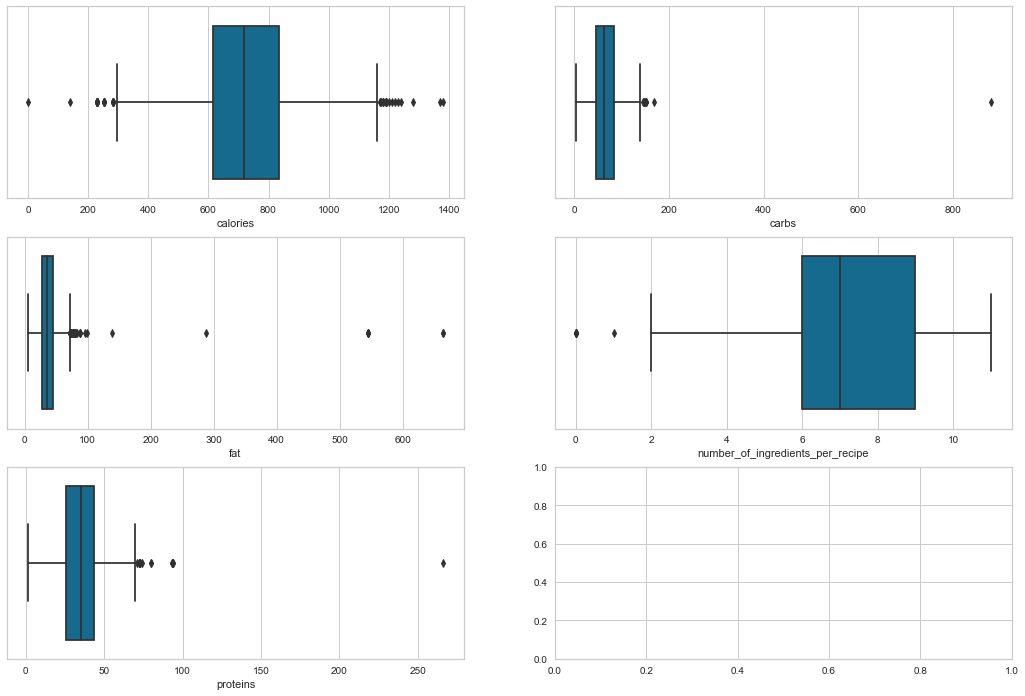

In [8]:
f, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 12))

sns.boxplot(x=data_df['calories'],ax=axes[0,0])
sns.boxplot(x=data_df['carbs'], ax=axes[0,1])
sns.boxplot(x=data_df['fat'], ax=axes[1,0])
sns.boxplot(x=data_df['number_of_ingredients_per_recipe'], ax=axes[1,1])
sns.boxplot(x=data_df['proteins'], ax=axes[2,0])


### What do we do with the outliers?

From the previous graphs we can see there are some outliers for some of the variables.
We can do several things:

- Keep them. Some algorithms are able to handle outliers. Sometimes the outliers can even be fundamental in building the regression.  

- Drop them. We need to be careful that we don't drop too much data (> 10%), specially if we don't have many rows. 

- Use a transformation such as log transformation. Logarithmic transformation is a way of transforming a highly skewed variable into a more normalized dataset. This will also  improve the fit of the model by transforming the distribution of the features to a more normally-shaped curve.






###### Target variable: Sales

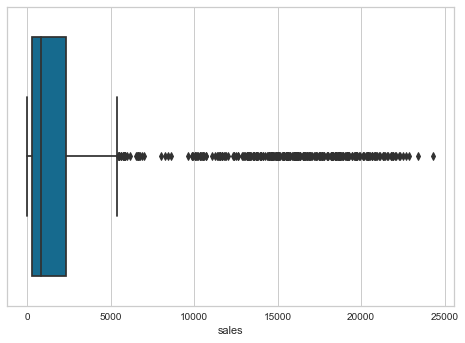

In [9]:
sns.boxplot(x=data_df['sales'])


We can see that the target variables is highly skewed and has very high values (up to 25.000), so it looks like we will have to treat it. 

## Data transformation
In this step we will prepare the training data-set for the modelling stage.

In [10]:
# The categorical variables
unilabel_cat_var = ['product_type', 'cooking_time', 'cuisine', 'dish_type', 'heat_level', 'protein_cuts']
multilabel_cat_var = ['preferences', 'carbs_content', 'dish_types', 'seasons', 'protein_types',  'meta_tags']

categorical_variables = []

# The continuous variables
continuous_variables = ['calories','carbs', 'fat', 'number_of_ingredients_per_recipe', 'proteins' ]


In [11]:
data_transf_df = data_df

### Drop the variables we have seen we don't need

In [12]:
data_transf_df = data_transf_df.drop(['cooking_tip', 
                                      'difficulty', 
                                      'is_classic', 
                                      'course_type', 
                                      'percentage_of_local_ingredients'], axis=1)

### Handle categorical variables : Multilabel variables and unilabel variables

The analysis above shows that some of the categorical variables include multiple labels in a single row. Thus, we need to dummify them in a different way: 

For instance, if we have:

{ 'record_1': 'fish, dairy',
  'record_2': 'dairy'}

The result should be:

{'record_1': {'col_fish': 1, 'col_dairy': 1},
 'record_1': {'col_fish': 0, 'col_dairy': 1}}

In [13]:
def create_unique_labels(list_of_lists):
    """ This function receibes a list of lists and returns a list with unique values"""
    unique_labels = [elem.split(',') for elem in list(list_of_lists.unique())]
    return list(set([item for sublist in unique_labels for item in sublist]))

def dummify_multilabel_var(data,column_name):
    # Get the unique labels for each category
    labels = create_unique_labels(data[column_name] )
    
    mlb = MultiLabelBinarizer()
    mlb.fit([labels])
    return pd.DataFrame(mlb.transform(data[multi_var].str.split(',')),columns= [ column_name + '_' + sub for sub in mlb.classes_] )

In [14]:
# DUMMITY MULTILABEL VARIABLES
# Just to make it more legible we will substitute nan-s with "Other"
data_transf_df[multilabel_cat_var] = data_transf_df[multilabel_cat_var].fillna("Other")

for multi_var in multilabel_cat_var:
    # Create dummies
    dummies = dummify_multilabel_var(data_transf_df,multi_var)
    
    # Let's concat to the main datafile and keep the record for the columns
    data_transf_df= pd.concat([data_transf_df, dummies], axis=1)
    categorical_variables = categorical_variables + list(dummies.columns)
    

In [15]:
# Just to make it more legible we will substitute nan-s with "Other"
data_transf_df[unilabel_cat_var] = data_transf_df[unilabel_cat_var].fillna("Other")
    
dummies = pd.get_dummies(data_transf_df[unilabel_cat_var], prefix=unilabel_cat_var)

# Let's concat to the main datafile and keep the record for the columns
data_transf_df= pd.concat([data_transf_df, dummies], axis=1)
categorical_variables = categorical_variables + list(dummies.columns)

In [16]:
print("In total we have {0} categorical variables ".format(str(len(categorical_variables))))

In total we have 147 categorical variables 


## Modelling

In [17]:
predictors = categorical_variables + continuous_variables
target = 'sales'


### Choosing the right algorithm
Since the target variable is a continuous variable, this is a <b>Regression problem</b>.
Looking at the predictors that we have, several algorithms could potentially help us predict sales. Some of those are:


- <b>Linear or polinomial regression </b>. We always try the most basic form of regression to get a feeling of the data.


- <b>Ridge Regression</b>. Includes L2 regularization and performs well when there is multicolinearity (which, given the amount of categorical variables we have, we might have) 


- <b>Lasso Regression</b>. Performs variable selection (L1 regularization) and therefore works well when we have many predictors (which is our case).


- <b>HuberRegressor</b>. This linear regression model is good for outliers. Looking at the initial analysis we can already see there are few outliers in the continuous variables.


- <b>XGBoostRegressor</b> This is a Gradient boosting regressor based on xgboost. Given the amount of categorical variables we have, a tree based algorithm might give us a better performance.


In this notebook I will just include Linear Regression and the XGBoostRegressor. I will run the Linear Regression just to get some sense of the data, even though due to the high amount of categorical variables it would not give good results. XGBoostRegressor can be a better option.


### Automatic transform of the target variable (Sales)
Adapting the scale of the target variable (Sales) is very important in order to get a well performing model. In the previous analysis we have already seen that our target variable is highly skewed, so we definitely need to transform it.


Of course, if we transform the target variable at the training stage we need to consider it at the evaluation and prediction stages. 


There are different ways of doing it:

- with a <b> TransformedTargetRegressor </b>.

- just transforming it and reverting the transformation after predicting. 



### Normalize continuous variables
In the previous analysis we have seen that the continuous variables have different scales. We need to normalize it in order to be able to run the Regression model.

For normalization I will use a MinMaxScaler.


Note: For the modelling exercise I've tried three different posiblities for the normalization:

- <b> Normalize continues variables and ignore outliers. </b> Just applying MinMaxScaler

- <b> First remove outliers and normalize afterwards. </b> Also with MinMaxScaler

- <b> Use log transformation to normalize the curve and incorporate outliers. </b> 


For this exercise I will just Normalize and ignore outliers. Nevertheles, I think we could still improve the results a bit by playing a bit with these techniques and trying different transformations.

It is also important to normalize after doing the train-test split to avoid data leakage, so that the model doesn't use information not available at prediction time.

In [18]:
# We need a different scaler for each variable, because we will need to use it␣ 
#later to scale the variables at prediction time
# We will store the scaler in a dictionary
def normalize_continuous_variables(continuous_variables, train, test):
    scalers_dic={}
    for sub in continuous_variables:
        pt=MinMaxScaler()
        scalers_dic.update({sub: pt })
        train[sub]=pt.fit_transform(train[[sub]])

        # I will take this chance to transform the test too
        test[sub]=pt.transform(test[[sub]])
    return [scalers_dic, train, test]

### Parameter-tuning: Calculating best metaparameters
ML algorithms have a number of metaparameters that can be tuned. 

Generally, for each parameter we can choose a set of values that could potentially work well, and then these are evaluated using GridSearch. 

This procedure can be done in your local machine, but if we want it to be fast <b>SageMaker</b> might be a better choice. 


In the interest of time for this exercise I won't include the Grid Search step and I will use some default values for the metaparameters.


### Missing data in Regression 
Some regression models such as Linear Regression don't work well with missing data. There are several things we can do:

- Remove rows with missing data. This is OK if we still have a lot of data and we only remove less than 10% of our data.

- Imputation. There are a number of techniques to fill the missing values. Like:

    * Using a default value
    
    * Using the mean or other metric from the column
    
    * Interpolation
    
    * Other methods like Monte Carlo imputation ...
   
   
The choice of the imputation method depends on the problem we want to solve and the data we have.
   
   
If we use Tree Based models missing values are not a big isue, the algorithm handles them well.


For the Linear Regressor, I will just drop rows with missing values  (but not for the XGBoostRegressor). 

### Model 1: Linear Regression

In [19]:
# Missing values
data_regr_df = data_transf_df[predictors + [target]].dropna()
print("Perfectage droped: " + str( 100 - (len(data_regr_df)/ len(data_transf_df) * 100 )))


Perfectage droped: 1.5991833957128279


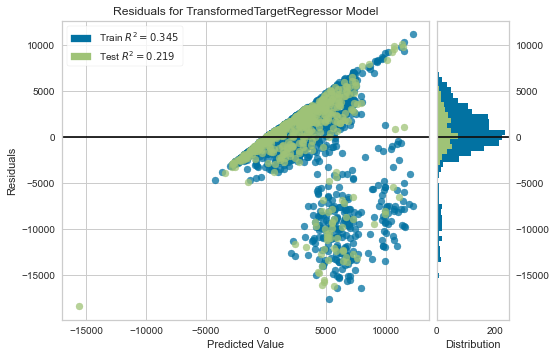

[3926.88145961 4050.47760329 4436.95779649 3754.50308478 4101.44448698
 3868.46064057 4075.02723687 4046.09444116 4099.9462321  4349.95723068]
Mean RMSE: 4070.975


In [20]:
# Create the train and test data
X_train, X_test, y_train, y_test = train_test_split(data_regr_df[predictors], data_regr_df[target],
                                                    test_size=0.2, random_state=42)

# Normalize continuous variables
[scalers_dic, X_train, X_test] =  normalize_continuous_variables(continuous_variables, X_train, X_test)


# Prepare the model with target scaling using MinMaxScaler
model = TransformedTargetRegressor(regressor=LinearRegression(), transformer=MinMaxScaler())


visualizer = ResidualsPlot(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure


# On top of it I'm crossvalidating to control overfitting, and calculating RMSE 
cv = KFold(n_splits=10, shuffle=True, random_state=1)
scores = cross_val_score(model, 
                         data_regr_df[predictors].to_numpy(), data_regr_df[target].to_numpy(), 
                         scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# convert scores to positive
scores = np.absolute(scores)
# summarize the result
s_mean = np.mean(scores)
print (scores)
print('Mean RMSE: %.3f' % (s_mean))

### What do we see here?

As a first step for an Regression problem it might be a good idea to try a simple Linear Regression, just to get some information about our variables. To evaluate the results I look at several things:


- <b> R square for the train and test sets </b>. This metric tells us how well the model can predict the target variable. If we are using the regression model just to understand the relationship between variables it doesn't matter how high this value is, but we would rather look at the model coefficients and the p values. On the other hand, if our objective is to build a predictive model, this value should be as high as possible. Also, the test R square should be slighly smaller than the train R square. If it is much smaller, it might be that the model is overfitting. Here, it doesn't look like it overfits, but the values are rather small for what we want (~0.329) .

- <b> Residuals plot .</b> This plot diplays the points with the errors and can help us a lot improving the model. A good residual plot should have the points spread around bellow and over the 0 error line, without showing a pattern. If you can detect a clear pattern or trend in your residuals, then your model has room for improvement. 

    * For the points under the 0 error line the model was "undershotting" its predictions

    * For the ones over 0, the model was "overshotting" its predictions.
    
    
In our plot we see a clear pattern, where the model undershoots low predictions and overshots as the predicted value increases. How could we fix this?
    
    * We can add more variables
    
    * We can try different variable transformations, in our case particularly for the sales variable which was highly skewed. Maybe a MinMaxScaler was not the right choice. 
    
    
- <b>  Root Mean Square Error (RMSE) </b>. This metric tells us about the errors in our prediction. We can use it to compare models (given that we use the same scale for the target variable). 

### Next steps:

- Since we have a high number of categorical variables, a tree based model might e=be a good fit. I will try XgboostRegressor because:
    
    * In can handle missing data and outliers quite well.
    
    * It's easy to prevent overfitting and it has a built in cross validation for eacg iteration.
    
    * It is quite fast and tends to perform well.

- Try to transform the target variable

### Model 2: XgboostRegressor
I will use <b>early_stopping_rounds </b> in order to avoid overfitting.

I will also use the log transformation for the target variable, in order to account for the long tale of the distribution and make it look more Gaussian-like.

In [23]:
data_regr_df = data_transf_df

# This parameters should be tuned with GridSearch to improve model performance.
# Here I have just used some default parameters
best_xgb_model = xgb.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=7,
                 min_child_weight=8.33883,
                 n_estimators=10000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=1)


[0]	validation_0-rmse:1.28473	validation_1-rmse:1.25818
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 70 rounds.
[1]	validation_0-rmse:1.19732	validation_1-rmse:1.17214
[2]	validation_0-rmse:1.11567	validation_1-rmse:1.09204
[3]	validation_0-rmse:1.04062	validation_1-rmse:1.01873
[4]	validation_0-rmse:0.97066	validation_1-rmse:0.95049
[5]	validation_0-rmse:0.90511	validation_1-rmse:0.88640
[6]	validation_0-rmse:0.84461	validation_1-rmse:0.82742
[7]	validation_0-rmse:0.78832	validation_1-rmse:0.77243
[8]	validation_0-rmse:0.73600	validation_1-rmse:0.72136
[9]	validation_0-rmse:0.68900	validation_1-rmse:0.67584
[10]	validation_0-rmse:0.64427	validation_1-rmse:0.63228
[11]	validation_0-rmse:0.60318	validation_1-rmse:0.59202
[12]	validation_0-rmse:0.56485	validation_1-rmse:0.55492
[13]	validation_0-rmse:0.53006	validation_1-rmse:0.52124
[14]	validation_0-rmse:0.49751	validation_1-rmse:0.48

[141]	validation_0-rmse:0.12494	validation_1-rmse:0.14881
[142]	validation_0-rmse:0.12486	validation_1-rmse:0.14880
[143]	validation_0-rmse:0.12477	validation_1-rmse:0.14883
[144]	validation_0-rmse:0.12458	validation_1-rmse:0.14888
[145]	validation_0-rmse:0.12441	validation_1-rmse:0.14881
[146]	validation_0-rmse:0.12431	validation_1-rmse:0.14886
[147]	validation_0-rmse:0.12415	validation_1-rmse:0.14903
[148]	validation_0-rmse:0.12394	validation_1-rmse:0.14920
[149]	validation_0-rmse:0.12385	validation_1-rmse:0.14928
[150]	validation_0-rmse:0.12373	validation_1-rmse:0.14928
[151]	validation_0-rmse:0.12359	validation_1-rmse:0.14920
[152]	validation_0-rmse:0.12338	validation_1-rmse:0.14928
[153]	validation_0-rmse:0.12331	validation_1-rmse:0.14926
[154]	validation_0-rmse:0.12317	validation_1-rmse:0.14924
[155]	validation_0-rmse:0.12309	validation_1-rmse:0.14933
[156]	validation_0-rmse:0.12300	validation_1-rmse:0.14931
[157]	validation_0-rmse:0.12279	validation_1-rmse:0.14918
[158]	validati

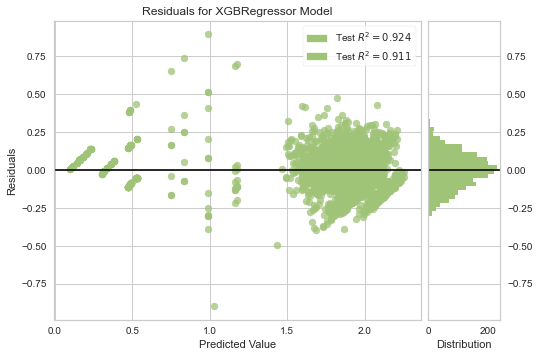

In [24]:

# Log-transform the target variable. 
data_regr_df[target] = np.log(data_regr_df[target])


# Create the train and test data
X_train, X_test, y_train, y_test = train_test_split(data_regr_df[predictors], data_regr_df[target],
                                                    test_size=0.2, random_state=42)

# Normalize continuous variables
[scalers_dic, X_train, X_test] =  normalize_continuous_variables(continuous_variables, X_train, X_test)


# We add the early_stopping_rounds parameter because otherwise it overfits
best_xgb_model.fit(X_train, y_train, early_stopping_rounds=70,
                   eval_set=[(X_train, y_train), (X_test, y_test)])

# Let's plot the residuals at the end to be able to compare with previous models
visualizer = ResidualsPlot(best_xgb_model)
visualizer.score(X_train, y_train)
visualizer.score(X_test, y_test)  
visualizer.show()  

### What do we see here?

Setting the early stopping rounds and adding the log transformation for the target variable have clearly helped getting a good results for out predictions.


R squared is close to 1 both for the train and testing sets, which is quite good. And the residuals and RMSE look also good. 


After this we can use the whole dataset to retrain the model and predict any new values.